In [2]:
import numpy as np
from scipy.stats import multivariate_normal as mvn
from scipy.stats import norm
import matplotlib.pylab as plt
np.set_printoptions(precision=2)

# Téma 6: Rekurzivní odhad, Kalmanův filtr

## Rekurzivní nejmenší čtverce

Uvažujme, že chceme odhadovat neznámý potenciálně vícerozměrný parametr $x$ rekurzivně z nových pozorování rovněž potenciálně vícerozměrné časové řady $y_t$, přičemž víme, že se jedná o lineární model

$$
y_t = H_t x + v_t,
$$

kde $H_t$ je matice kompatibilního rozměru a $v_t$ je nezávislý stejně rozdělený šum s kovariancí $R$ a nulovou střední hodnotou, $v_t\sim (0, R)$. Tento odhad můžeme provádět pomocí [rekurzivních nejmenších čtverců](https://en.wikipedia.org/wiki/Recursive_least_squares_filter) - RLS (recursive least squares). Předpokládáme zde, že parametry $x$ jsou konstantní. Až se budou v čase měnit, nazveme je stavy a budeme potřebovat Kalmanův filtr.

> ### Příklad

> Uvažujme následující ilustrativní příklad: Měříme v diskrétních časových okamžicích $t=1,2,\ldots$, konkrétně každou sekundu, rychlost rovnoměrně akcelerujícího objektu. Tu označíme $y_t$, měříme v m/s. Nepřesnosti měření způsobené chybami měřící soustavy vysvětlujeme v nule centrovaným nezávislým stejně rozděleným šumem s variancí $R$. Z měření máme online odhadovat:

> - počáteční rychlost $y_0$
> - zrychlení $a$

> Tyto veličiny budou po dobu měření konstantní.

> Model si přepíšeme podle rovnice:

> $$
y_t = v_0 + a\cdot t + v_t = H_t x_t + v_t, \qquad\text{kde}\qquad
H_t =
\begin{bmatrix}
1 \\ t
\end{bmatrix},
\qquad
x_t =
\begin{bmatrix}
y_0 \\ a
\end{bmatrix},
\qquad v_t \sim (0, R).
$$

> Podívejme se na simulaci, poté odvodíme RLS a zkusíme je nasadit.

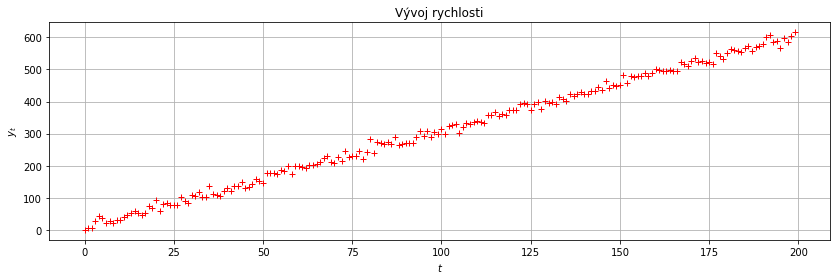

In [3]:
ndat = 200
R = 10**2

y0 = 10                   # Toto číslo budeme odhadovat
a = 3                     # a toto také
x = np.array([[y0], [a]])

y = np.zeros(ndat)
for t in range(1, ndat):
    Ht = np.array([1, t])
    y[t] = Ht.dot(x) + np.random.normal(scale=np.sqrt(R))

plt.figure(figsize=(14,4))
plt.plot(y, 'r+')
plt.xlabel(r'$t$')
plt.ylabel(r'$y_t$')
plt.title('Vývoj rychlosti')
plt.show()

## Odhadování pomocí korekce

Budeme uvažovat, že hodnotu odhadu $\hat{x}_t$ můžeme postavit na hodnotě předchozí, $\hat{x}_{t-1}$:

$$
\hat{x}_t = \hat{x}_{t-1} + K_t(y_t - H_t \hat{x}_{t-1}),
$$

kde $\hat{x}_t$ je odhad neznámého parametru $x$ učiněný v čase $t$ a $K_t$ je zesílení, které pracuje s korekcí (chybou) $y_t - H_t \hat{x}_{t-1}$. Povšimněme si, jak se bude odhad chovat pro různá zesílení. Chceme, aby s $t\to\infty$ konvergoval odhad parametru k jeho skutečné hodnotě $\hat{x}_t \to x$.

## Vlastnosti odhadu

$$
\begin{aligned}
\mathbb{E}[x-\hat{x}_{t}] 
&= \mathbb{E}[x-\hat{x}_{t-1} - K_t(y_t - H_t \hat{x}_{t-1})] \\ 
&= \mathbb{E}[x-\hat{x}_{t-1} - K_t(H_t x + v_t - H_t \hat{x}_{t-1})] \\ 
&= \mathbb{E}\left[x-\hat{x}_{t-1} - K_t[H_t (x - \hat{x}_{t-1}) + v_t]\right] \\ 
&= \mathbb{E}\left[x-\hat{x}_{t-1} - K_t H_t (x - \hat{x}_{t-1}) + K_t v_t \right] \\ 
&= \mathbb{E}\left[(I - K_t H_t)(x - \hat{x}_{t-1}) + K_t v_t \right].
\end{aligned}
$$

Koukneme-li na to zblízka, pak je zřejmé, že pokud $\mathbb{E}[v_t] = 0$ a současně $\mathbb{E}[x-\hat{x}_{t-1}]=0$, potom i $\mathbb{E}[x-\hat{x}_{t}]=0$. Tedy, pokud spustíme odhad z $\hat{x}_0 = \mathbb{E}[x]$, pak každý odhad $\hat{x}_t = x$ pro všechna $t$. To znamená, že odhad je **nevychýlený**. Navíc tato vlastnost platí pro každé zesílení $K_t$.

# Optimální zesílení $K_t$

Vzpomeňme na metodu nejmenších čtverců. Optimální zesílení nechť minimalizuje součet čtverců $(x_1-\hat{x}_1)^2,\ldots, x_n-\hat{x}_n)^2)$, kde $n$ je rozměr $x$. Budeme pracovat ve středních hodnotách, tedy definujme

$$
\begin{aligned}
J_t 
&= \mathbb{E}[(x_1-\hat{x}_1)^2] + \ldots + \mathbb{E}[(x_1-\hat{x}_1)^2] \\
&= \mathbb{E}[(x_1-\hat{x}_1)^2 + \ldots + (x_1-\hat{x}_1)^2] \\
&=
\mathbb{E} \left\{ \operatorname{Tr}
\begin{bmatrix}
(x_1 - \hat{x}_1)^2 & 0 & \ldots & 0 \\
0 & (x_1 - \hat{x}_1)^2 & \ldots & 0 \\
\vdots & & \ddots & \vdots \\
0 &\ldots & \ldots & (x_n - \hat{x}_n)^2
\end{bmatrix}
\right\} \\
&= \operatorname{Tr} P_t.
\end{aligned}
$$

Matici $P_t$ nazveme **kovarianční maticí odhadu** $\hat{x}_t$. Je diagonální a pozitivně semidefinitní. Platí pro ni

$$
\begin{aligned}
P_t 
&= \mathbb{E}\left[ (x-\hat{x}_t)(x-\hat{x}_t)^\intercal \right] \\
&= \mathbb{E}\left[ \{(I - K_t H_t)(x - \hat{x}_{t-1}) + K_t v_t\} \{\circ\}^\intercal \right] \\
&= (I - K_t H_t) P_{t-1} (I - K_t H_t)^\intercal + K_t R_t K_t.
\end{aligned}
$$

Vidíme, že celkem očekávaně roste-li kovariance šumu, roste i kovariance odhadů. S neurčitostí měření roste neurčitost odhadů.

Budeme minimalizovat $J_k$ vzhledem k $K_t$. Z analýzy bychom mohli vědět, že je-li $A$ symetrická matice, pak

$$
\frac{\partial\operatorname{Tr}(XAX^T)}{\partial X} = 2XA.
$$

Tedy

$$
\frac{\partial J_t}{\partial K_t} = 2(I-K_t H_t)P_{t-1} (-H_t^\intercal) + 2K_t R_t = 0
$$

z čehož dostaneme vztah pro $K_t$:

$$
K_t = P_{t-1} H_t^\intercal (H_t P_{t-1} H_t^\intercal + R_t)^{-1}.
$$

## Algoritmus RLS

1. Inicializuj odhady

$$
\hat{x}_0 = \mathbb{E}[x], \qquad P_0 = \mathbb{E}[(x-\hat x_0)(x-\hat x_0)^\intercal].
$$

2. Pro časy $t=1,2,\ldots$:

    i. Získej pozorování $y_t$,
    
    ii. updatuj odhady
    
$$
\begin{aligned}
K_t &= P_{t-1} H_t^\intercal (H_t P_{t-1} H_t^\intercal + R_t)^{-1},\\
\hat{x}_t &= \hat{x}_{t-1} + K_t(y_t - H_t \hat{x}_{t-1}), \\
P_t &= (I - K_t H_t) P_{t-1} (I - K_t H_t)^\intercal + K_t R_t K_t.
\end{aligned}
$$

> ### Zpět k příkladu
> Následující kód ukáže, že RLS odhad docela dobře funguje :) Na obrázku níže je vidět konvergence ke skutečným hodnotám parametrů $y_0$ a $a$. Připomeňme, že odhady vznikaly online, tedy s každým novým měřením $y_t$ byl odhadnut vektor $x_t = [y_0, a]^\intercal$.

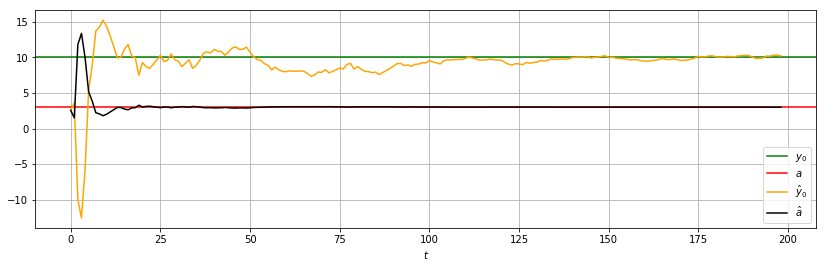

In [6]:
x_estimates = []
x_est = np.zeros(2)
P = np.eye(2) * 10000

for t in range(1, ndat):
    Ht = np.array([[1, t]])
    zavorka = Ht.dot(P).dot(Ht.T) + R
    K = P.dot(Ht.T) / zavorka
    x_est = x_est + K.dot(y[t] - Ht.dot(x_est))
    zavorka_P = np.eye(2) - np.outer(K, Ht)
    P = zavorka_P.dot(P).dot(zavorka_P.T) + R * np.outer(K, K)
    x_estimates.append(x_est.copy())
    
x_estimates = np.array(x_estimates)
plt.figure(figsize=(14,4))
plt.axhline(y=y0, color='green', label=r'$y_0$')
plt.axhline(y=a, color='red', label=r'$a$')
plt.plot(x_estimates[:,0], color='orange', label=r'$\hat{y}_0$')
plt.plot(x_estimates[:,1], color='black', label=r'$\hat{a}$')
plt.xlabel(r'$t$')
plt.legend()
plt.show()

# Kalmanův filtr

Předpokládejme nyní, že i $x$ se vyvíjí v čase podle nějakého známého lineárního modelu. Označíme jej $x_t$.

## Motivační příklad (ne tak úplně časová řada)

Uvažujme, že pozorujeme těleso vržené vzhůru a zajímá nás jeho rychlost $v_t$ a "přesná" výška $h_t$, které budeme nazývat **stavovými proměnnými** (nebo **stavem**). $t=1,2,\ldots$ jsou diskrétní časové okamžiky (např. sekundy). K dispozici máme nepřesná (tedy zašuměná) **měření** výšky získaná z GPS, tato měření označme $y_{h,t}$. Pro jednoduchost zanedbáme vliv odporových sil.

Ze středoškolské fyziky (a pro přítomnost šumu i statistiky) víme, že pro výšku $h_t$ a rychlost $v_t$ v čase $t$ platí

$$
\begin{aligned}
h_t &= h_{0} + v_0 \Delta_t - \frac{1}{2} g \Delta_t^2 + w_{h,t}, \\
v_t &= v_0 - g\Delta_t + w_{v,t},
\end{aligned}
$$

kde $g = 9.81ms^{-2}$ je gravitační zrachlení, $v_0$ je počáteční rychlost, $y_0$ je počáteční výška a $\Delta_t = t-t_0$ je doba od počátečního času $t_0$. Zpravidla $t_0 = 0$, čímž se z $\Delta_t$ stane jen $t$ a dostaneme vzorečky na něž jsme byli na střední škole zvyklí. Členy $w_{h,t}$ a $w_{v,t}$ představují šum na přítomných stavových veličinách.

Všimněme si, že **stav** je vlastně jakýsi **parametr** celého tohoto modelu, jenže narozdíl od klasického parametru se nám vyvíjí. Rychlost tělesa vrženého vzhůru bude klesat, zatímco výška bude stoupat.

V předmětu jsme si zvykli na sekvenční (online) modelování. Protože bychom chtěli podobně přistoupit k $h_t$ a $v_t$, jež se nám ale v čase vyvíjí, potřebovali bychom model trochu upravit, aby tento časový vývoj z času $t-1$ na čas $t$ zohlednil. Model si tedy přepíšeme:

$$
\begin{aligned}
h_t &= h_{t-1} + v_{t-1} \Delta_t - \frac{1}{2} g \Delta_t^2,\\
v_t &= v_{t-1} - g \Delta_t.
\end{aligned}
$$

Chceme-li modelovat více veličin současně, přepíšeme model do maticové podoby:

$$
\underbrace{
\begin{bmatrix}
h_t \\
v_t
\end{bmatrix}
}_{x_t}
=
\underbrace{
\begin{bmatrix}
1 & \Delta_t \\
0 & 1
\end{bmatrix}
}_{A_t}
\underbrace{
\begin{bmatrix}
h_{t-1} \\
v_{t-1}
\end{bmatrix}
}_{x_{t-1}}
+
\underbrace{
\begin{bmatrix}
- \frac{1}{2}\Delta_t^2 \\
- \Delta_t
\end{bmatrix}
}_{B_t}
\underbrace{
g
}_{u_t}
+
\underbrace{
\begin{bmatrix}
w_{h,t} \\
w_{v,t}
\end{bmatrix}
}_{w_t}.
$$

Připomeňme, že máme i zašuměná měření výšky z GPS, označená jako $y_{h,t}$. Ta zapíšeme jednoduše

$$
y_{h,t} = h_t + v_t.
$$

Jelikož máme ale vektor stavů, můžeme použít ekvivalentní zápis

$$
y_{h,t}
=
\underbrace{
\begin{bmatrix}
1 & 0 \\
\end{bmatrix}
}_{H_t}
x_t
+ v_t.
$$

### Výsledný stavový model:
$$
\begin{aligned}
x_t &=
\begin{bmatrix}
1 & \Delta_t \\
0 & 1
\end{bmatrix}
x_{t-1}
+
\begin{bmatrix}
- \frac{1}{2}\Delta_t^2 \\
- \Delta_t
\end{bmatrix}
g
+
\begin{bmatrix}
w_{h,t} \\
w_{v,t}
\end{bmatrix}
\\
y_{h,t}
&=
\begin{bmatrix}
1 & 0
\end{bmatrix}
x_t
+ v_t.
\end{aligned}
$$

>**OBECNĚ**
>$$
\begin{aligned}
x_t &= A_t x_{t-1} + B_t u_t + w_t, \\
y_t &= H_t x_t + v_t,
\end{aligned}
$$
>
> kde $x_t$ je **stav**, $u_t$ je **řídící veličina**, $w_t$ a $v_t$ jsou **šum stavu** a **šum měření** a $A_t, B_t$ a $H_t$ jsou matice patřičných rozměrů.

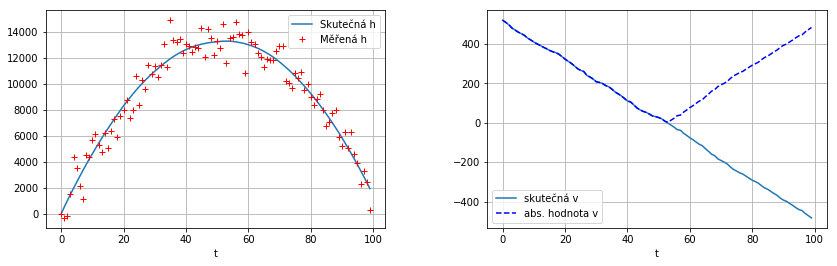

In [7]:
ndat = 100                               ### počet dat
h0 = 0                                   ### počáteční výška [m]
v0 = 520                                 ### počáteční rychlost [m/s]
g = 9.81                                 ### grav. zrychlení [m/s^2]
dt = 1                                   # čas. krok v sekundách
A = np.array([[1, dt], [0, 1]])          # matice A
B = np.array([-.5*dt, -dt])              # matice B
u = g                                    # pro forma, g=u
var_wht = 10                             ### variance šumu na výšce w_ht
var_wvt = 10                             ### variance šumu na rychlosti w_vt
var_y = 1000**2                            ### variance šumu měření v_t

x = np.zeros((2, ndat))
x[:,0] = [h0, v0]
y = np.zeros(ndat)

for t in range(1, ndat):
    x[:,t] = A.dot(x[:,t-1]) + B.dot(u)
    x[:,t] += mvn.rvs(cov=np.diag([var_wht, var_wvt]))
    y[t] = x[0,t] + norm.rvs(scale=np.sqrt(var_y))
    
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(x[0], label='Skutečná h')
plt.plot(y, '+r', label='Měřená h')
plt.legend()
plt.xlabel('t')
plt.subplot(122)
plt.plot(x[1], label='skutečná v')
plt.plot(np.abs(x[1]), '--b', label='abs. hodnota v')
plt.legend()
plt.xlabel('t')
plt.show()

# Kalmanův filtr

- autorství je připisováno americkém matematikovi a inženýrovi maďarského původu Rudolfu E. Kálmánovi.
- podobné algoritmy ale vznikaly i o něco dříve (Swerling, Thiele), souběžně (Bucy).
- obecnější filtr v pojetí stochastické analýzy navrhl dříve sovětský matematik Ruslan Stratonovič. KF je jeho speciálním případem.
- první aplikace - S.F. Schmidt - program Apollo (navigace).
![Kalman](img/Rudolf_Kalman.jpg)

### Aplikace: 
- Apollo (navigace)
- zbraňové systémy (ponorky, rakety, střely Tomahawk)
- navigační systémy obecně
- autopiloty
- computer vision (https://www.youtube.com/watch?v=dKpRsdYSCLQ, https://www.youtube.com/watch?v=O4fVQKigutk)
- radar tracking
- modely v ekonometrii
- inerciální navigační systémy
- bezsenzorové řízení AC elektromotorů
- předpovědi počasí
- a spousty dalších. V mobilech, autech...

# Odvození

Odvození Kalmanova filtru postavíme na dvou věcech:

1. Využití rekurzivních nejmenších čtverců - pomocí měření $y_t$ můžeme odhad zpřesňit.
2. Časový vývoj parametrů - propagace kovariance stavů a vývoj stavů skrz teoretický model, bez měření.

# Kalmanův filtr

Předpokládejme, že stavy se navíc vyvíjí podle modelu

$$
x_t = A_t x_{t-1} + B_t u_t + w_t, \qquad w_t\sim \operatorname{iid}\  (0, Q_t),
$$

kde $A_t$ a $B_t$ jsou matice odpovídajících rozměrů, $u_t$ je externí veličina (někdy zvaná řídící) a šum $w_t$ je centrovaný v nule.

Označme odhad

$$
\bar{x}_t = \mathbb{E}[x_t] = A_t \bar{x}_{t-1} + B_t u_t.
$$

Potom

$$
\begin{aligned}
P_t
&= \mathbb{E}[(x_t - \bar{x}_t)(x_t - \bar{x}_t)^\intercal] \\
&= \mathbb{E}[(A_t x_{t-1} + B_t u_t + w_t - \bar{x}_t)\cdot(\circ)^\intercal] \\
&= \mathbb{E}[\{A_t(x_{t-1}- \bar{x}_t) + w_t\}\cdot\{\circ\}^\intercal] \\
&= \mathbb{E}[A_t(x_{t-1}- \bar{x}_t)(x_{t-1}- \bar{x}_t)^\intercal A_t^\intercal + w_t w_t^\intercal] \\
&= A_t P_{t-1} A_t^\intercal + Q_t.
\end{aligned}
$$

Z toho plyne, že pokud se vyvíjí stav $x_t$ podle nějakého modelu, vyvíjí se i jeho odhad a kovariance odhadů. Opět se do kovariance odhadů promítá kovariance šumu procesu.

## Stavový model

Stavový model (angl. [state-space model](https://en.wikipedia.org/wiki/State-space_representation)) je model ve tvaru

$$
\begin{align}
x_t &= A_t x_{t-1} + B_t u_t + w_t, &w_t \sim (0, Q_t),\\
y_t &= H_t x_t + v_t, &v_t \sim (0, R_t).
\end{align}
$$

Šumové složky jsou navíc nezávislé mezi sebou. Označme dále **apriorní a aposteriorní odhady a kovariance odhadů**

$$
\begin{align}
\hat{x}_t^{-} &= \mathbb{E}[x_t|y_1,\ldots,y_{t-1}] &\text{s kovariancí}\quad P_t^{-},\\
\hat{x}_t^{+} &= \mathbb{E}[x_t|y_1,\ldots,y_{t}]&\text{s kovariancí}\quad P_t^{+}.
\end{align}
$$

## Algoritmus Kalmanova filtru
**Inicializace:** Nastavíme $x_0$ (iniciální odhad stavu) a $P_0^+$ (iniciální kovariance odhadů).

**Pro $t=1,2,\ldots$:**

    Predikce stavů (časový update)
$$
\begin{align}
\hat{x}_t^{-} &= A_t \hat{x}_{t-1}^{+} + B_t u_t,\\
P_t^{-} &= A_t P_{t-1}^{+} A_t^\intercal + Q_t.
\end{align}
$$

    Korekce (datový update) stavů pozorováním $y_t$
$$
\begin{aligned}
K_t &= P_{t-1} H_t^\intercal (H_t P_{t}^{-} H_t^\intercal + R_t)^{-1},\\
\hat{x}_t &= \hat{x}_{t}^{-} + K_t(y_t - H_t \hat{x}_{t}^{-}), \\
P_t^{+} &= (I - K_t H_t) P_{t}^{-} (I - K_t H_t)^\intercal + K_t R_t K_t.
\end{aligned}
$$

# Zpátky k příkladu...

In [8]:
x_estimates = []
x_plus = np.zeros(2)
P_plus = np.eye(2) * 10000

Q = np.diag([var_wht, var_wvt])           # Toto už jsme v simulaci také udělali
R = var_y
H = np.array([1, 0])

for t in range(ndat):
    # Predikce
    x_minus = A.dot(x_plus) + B.dot(u)
    P_minus = A.dot(P_plus).dot(A.T) + Q
    
    # Update
    zavorka = H.dot(P_minus).dot(H.T) + R
    K = P_minus.dot(H.T) / zavorka
    #K = 0.1 * np.ones(2)
    x_plus = x_minus + K.dot(y[t] - H.dot(x_minus))
    zavorka_P = np.eye(2) - np.outer(K, H)
    P_plus = zavorka_P.dot(P_minus).dot(zavorka_P.T) + R * np.outer(K, K)
    x_estimates.append(x_plus.copy())

x_estimates = np.array(x_estimates)

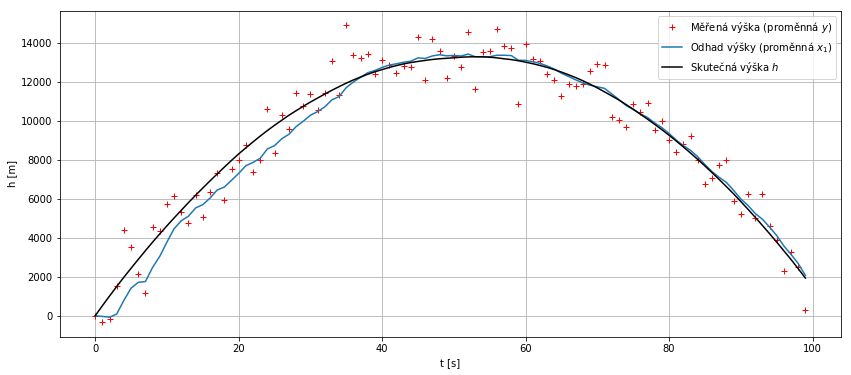

In [9]:
plt.figure(figsize=(14,6))
plt.plot(y, '+r', label=r'Měřená výška (proměnná $y$)')
plt.plot(x_estimates[:,0], label=r'Odhad výšky (proměnná $x_1$)')
plt.plot(x[0], 'k', label=r'Skutečná výška $h$')
plt.legend()
plt.xlabel('t [s]')
plt.ylabel('h [m]')
plt.show()

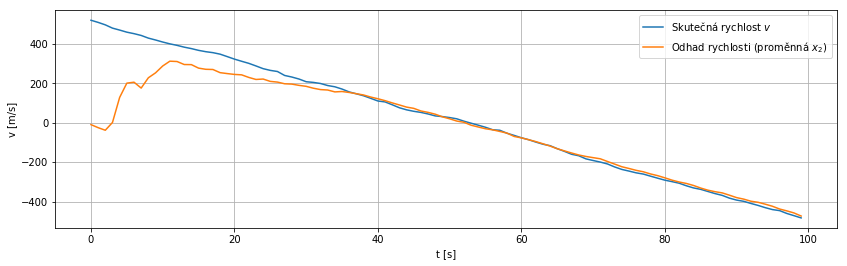

In [10]:
plt.figure(figsize=(14,4))
plt.plot(x[1], label=r'Skutečná rychlost $v$')
plt.plot(x_estimates[:,1], label=r'Odhad rychlosti (proměnná $x_2$)')
plt.xlabel('t [s]')
plt.ylabel('v [m/s]')
plt.legend()
plt.show()

## Vlastnosti Kalmanova filtru

- jsou-li obě šumové složky normálně rozdělené, centrované v nule, nekorelované a bílé, potom je Kalmanův filtr optimální lineární filtr.
- pokud není zajištěna normalita, je Kalmanův filtr stále nejlepší lineární filtr. To jest, může existovat lepší (např. nelineární) filtr, ale KF je stále nejlepší lineární.
- pokud jsou šumy korelované nebo barevné, existují různé modifikace.
- je-li proces nelineární, lze použít rozšířený KF nebo jiné varianty filtru.